In [62]:
import networkx as nx
import numpy as np
from matplotlib import lines
import matplotlib.pyplot as plt
import pandas as pd
from pyproj import Transformer
import random
import shapefile
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool, global_max_pool
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Data Preparation

## Reading Data

In [3]:
dataset = pd.read_csv('restructured_daily.csv')

In [4]:
dataset

TRGCODE      HOBLINAME  LATITUDE  LONGITUDE  2015-06-01  2015-06-02  \
0          99  Yeshwantapura     12.99      77.52         0.5         0.0   
1         101       Sulepeth     17.40      77.35         0.0         0.0   
2         102          Aurad     17.44      76.90         0.0         0.0   
3         103      Kamalapur     17.58      76.99         0.0         0.0   
4         104       Mahagaon     17.54      76.88         0.0         0.0   
...       ...            ...       ...        ...         ...         ...   
3927     7841          Sirsi     14.56      74.83         0.0         0.0   
3928     7842          Sirsi     14.57      74.87         0.0         0.0   
3929     7843          Sirsi     14.58      74.82         0.0         0.0   
3930     7846    Supa(Joida)     15.30      74.54         0.0         0.0   
3931     7851      Manchiker     14.80      74.81         0.0         0.0   

      2015-06-03  2015-06-04  2015-06-05  2015-06-06  ...  2022-09-21  \
0            5.0         7.0         0.5         0.0  ...         0.0   
1            0.0         0.0         0.0         0.0  ...         0.0   
2            0.0         0.0         3.5         0.0  ...         0.0   
3            0.0         7.5         0.0         0.5  ...         0.0   
4            0.0         0.0         0.0         0.0  ...         0.0   
...          ...         ...         ...         ...  ...         ...   
3927         0.0         0.2         3.0         0.0  ...         0.5   
3928         0.0         0.0         0.0         0.0  ...         0.0   
3929         0.0         0.5         0.2         0.0  ...         2.5   
3930         0.0         0.0         0.0         1.3  ...         0.0   
3931         0.0         3.8         0.0         0.0  ...         0.0   

      2022-09-22  2022-09-23  2022-09-24  2022-09-25  2022-09-26  2022-09-27  \
0            0.0         0.0         8.0         0.0        15.0         0.5   
1            0.0         0.0         0.0         0.0         0.0         0.0   
2            0.0         0.0         0.0         0.0         0.5         0.5   
3            0.0         0.0         0.0         4.0         8.5         0.0   
4            0.0         0.0         0.0         0.5        17.0         0.0   
...          ...         ...         ...         ...         ...         ...   
3927         0.0         6.5         2.5         0.0         0.0         0.0   
3928         0.0         0.0         0.0         0.0         0.0         0.0   
3929         2.5         2.5         1.5         1.5         2.0         1.0   
3930         0.0         1.0         0.5         0.0         0.0         0.0   
3931         0.5         4.0         0.5         0.5         0.0         0.0   

      2022-09-28  2022-09-29  2022-09-30  
0            0.0         0.0         6.5  
1            0.0         0.0         0.0  
2           22.5         9.5         0.0  
3            1.0        12.5         0.0  
4            0.0         2.5         0.0  
...          ...         ...         ...  
3927         0.0         0.0        10.5  
3928         0.0         0.0         0.0  
3929         0.0         0.0         3.0  
3930         0.0         0.0        33.0  
3931         0.0         0.0        17.5  

[3932 rows x 980 columns]

In [5]:
dataset.describe()

TRGCODE     LATITUDE    LONGITUDE   2015-06-01   2015-06-02  \
count  3932.000000  3932.000000  3932.000000  3932.000000  3932.000000   
mean   3626.179552    14.388721    76.273548     3.913708     2.664140   
std    2277.198160     1.640077     0.986107     8.807838     7.963733   
min      99.000000    11.650000    74.110000     0.000000     0.000000   
25%    1498.500000    13.040000    75.480000     0.000000     0.000000   
50%    3375.500000    14.000000    76.320000     0.500000     0.000000   
75%    5359.750000    15.760000    77.040000     3.700000     0.700000   
max    7851.000000    18.390000    78.560000   190.500000    84.000000   

        2015-06-03   2015-06-04   2015-06-05   2015-06-06   2015-06-07  ...  \
count  3932.000000  3932.000000  3932.000000  3932.000000  3932.000000  ...   
mean      2.071312     6.855061     1.137030     0.687996     0.975203  ...   
std       7.354733    12.678925    10.119662     3.563426     3.707525  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
50%       0.000000     0.800000     0.000000     0.000000     0.000000  ...   
75%       0.000000     8.000000     0.200000     0.000000     0.000000  ...   
max     100.500000   121.500000   586.000000    52.100000    54.500000  ...   

        2022-09-21   2022-09-22   2022-09-23   2022-09-24   2022-09-25  \
count  3932.000000  3932.000000  3932.000000  3932.000000  3932.000000   
mean      0.198932     0.216531     1.465056     1.000407     0.839013   
std       1.216795     1.423734     4.978187     3.153658     4.273468   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     0.000000     0.000000     0.000000     0.000000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.000000     0.000000     0.500000     0.500000     0.000000   
max      24.500000    29.000000    55.500000    65.000000    76.000000   

        2022-09-26   2022-09-27   2022-09-28   2022-09-29   2022-09-30  
count  3932.000000  3932.000000  3932.000000  3932.000000  3932.000000  
mean      2.029222     0.135249     1.323957     4.067472     9.582579  
std       6.710487     1.571676     6.227718    10.418618    13.886600  
min       0.000000     0.000000     0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000     0.000000     0.000000  
50%       0.000000     0.000000     0.000000     0.000000     3.000000  
75%       0.500000     0.000000     0.000000     2.000000    14.500000  
max     131.000000    73.000000    95.000000   108.000000   149.000000  

[8 rows x 979 columns]

In [6]:
## In start:stop, stop is excluseive
dataset['MEAN'] = dataset.iloc[:, 4:980].mean(axis=1)
dataset['STD'] = dataset.iloc[:, 4:980].std(axis=1)
dataset['MEDIAN'] = dataset.iloc[:, 4:980].median(axis=1)
dataset['IQR'] = dataset.iloc[:, 4:980].quantile(0.75, axis=1) - dataset.iloc[:, 4:980].quantile(0.25, axis=1)

In [7]:
dataset

TRGCODE      HOBLINAME  LATITUDE  LONGITUDE  2015-06-01  2015-06-02  \
0          99  Yeshwantapura     12.99      77.52         0.5         0.0   
1         101       Sulepeth     17.40      77.35         0.0         0.0   
2         102          Aurad     17.44      76.90         0.0         0.0   
3         103      Kamalapur     17.58      76.99         0.0         0.0   
4         104       Mahagaon     17.54      76.88         0.0         0.0   
...       ...            ...       ...        ...         ...         ...   
3927     7841          Sirsi     14.56      74.83         0.0         0.0   
3928     7842          Sirsi     14.57      74.87         0.0         0.0   
3929     7843          Sirsi     14.58      74.82         0.0         0.0   
3930     7846    Supa(Joida)     15.30      74.54         0.0         0.0   
3931     7851      Manchiker     14.80      74.81         0.0         0.0   

      2015-06-03  2015-06-04  2015-06-05  2015-06-06  ...  2022-09-25  \
0            5.0         7.0         0.5         0.0  ...         0.0   
1            0.0         0.0         0.0         0.0  ...         0.0   
2            0.0         0.0         3.5         0.0  ...         0.0   
3            0.0         7.5         0.0         0.5  ...         4.0   
4            0.0         0.0         0.0         0.0  ...         0.5   
...          ...         ...         ...         ...  ...         ...   
3927         0.0         0.2         3.0         0.0  ...         0.0   
3928         0.0         0.0         0.0         0.0  ...         0.0   
3929         0.0         0.5         0.2         0.0  ...         1.5   
3930         0.0         0.0         0.0         1.3  ...         0.0   
3931         0.0         3.8         0.0         0.0  ...         0.5   

      2022-09-26  2022-09-27  2022-09-28  2022-09-29  2022-09-30       MEAN  \
0           15.0         0.5         0.0         0.0         6.5   4.107070   
1            0.0         0.0         0.0         0.0         0.0   2.851947   
2            0.5         0.5        22.5         9.5         0.0   4.523053   
3            8.5         0.0         1.0        12.5         0.0   4.776639   
4           17.0         0.0         0.0         2.5         0.0   3.996926   
...          ...         ...         ...         ...         ...        ...   
3927         0.0         0.0         0.0         0.0        10.5  14.738012   
3928         0.0         0.0         0.0         0.0         0.0   5.763422   
3929         2.0         1.0         0.0         0.0         3.0  10.823053   
3930         0.0         0.0         0.0         0.0        33.0   6.812705   
3931         0.0         0.0         0.0         0.0        17.5   9.039344   

            STD  MEDIAN     IQR  
0     10.348445    0.00   3.000  
1      8.830068    0.00   1.000  
2     11.894159    0.00   3.500  
3     10.767511    0.00   4.000  
4     12.301344    0.00   2.000  
...         ...     ...     ...  
3927  24.781632    3.80  18.725  
3928  13.538448    0.00   4.825  
3929  20.011957    1.95  12.900  
3930  15.985495    0.00   6.500  
3931  18.487978    0.50  10.550  

[3932 rows x 984 columns]

Text(0, 0.5, 'Frequency')

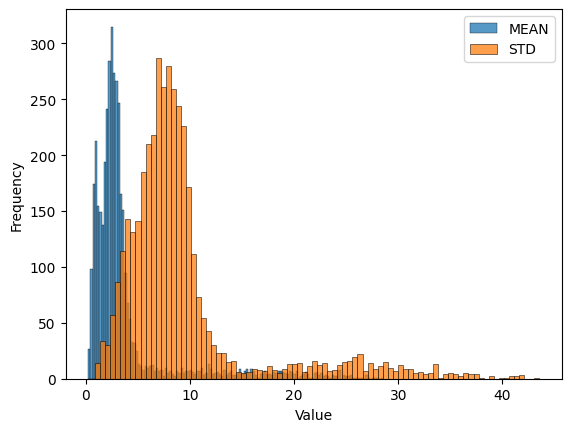

In [8]:
sns.histplot(dataset['MEAN'], label="MEAN")
sns.histplot(dataset['STD'], label="STD")
plt.legend()
plt.xlabel("Value")
plt.ylabel("Frequency")

In [9]:
trgcodes = dataset['TRGCODE'].unique()
print(len(trgcodes))

3932


The randomly selected TRGCODE is 4073


<Axes: ylabel='Count'>

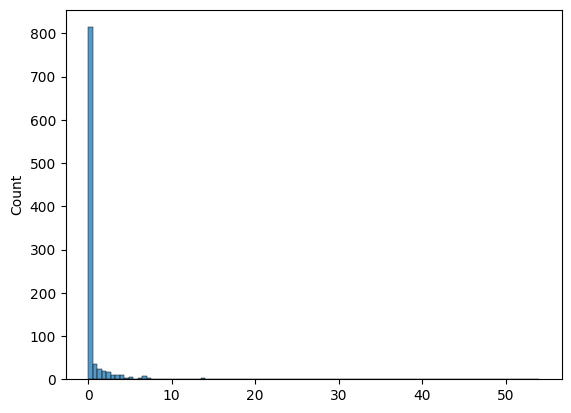

In [10]:
rand_trg = np.random.choice(trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

sns.histplot(dataset.loc[dataset['TRGCODE'] == rand_trg].iloc[0, 4:980].values, bins=100)

## Creating Some Useful Data Containers

### Make `year_wise_dict`

In [11]:
years = list(range(2015, 2023))

year_wise_dict = {}

year_columns = {
    year: [col for col in dataset.columns if str(year) in str(col)]
    for year in years
}

col_positions = {col: i for i, col in enumerate(dataset.columns)}

## itertuples is faster than iterrows, but it cannot alter the accessed data
for row in dataset.itertuples(index=False):
    trgcode = row.TRGCODE

    year_wise_dict[trgcode] = {}

    for year in years:
        cols = year_columns[year]

        rainfall_vector = [row[col_positions[col]] for col in cols]
        year_wise_dict[trgcode][year] = np.array(rainfall_vector)

### Calculate `cos_sims`

In [12]:
cos_sim_dict = {}

for trgcode in trgcodes:

    vectors = [year_wise_dict[trgcode][year] for year in years]
    tensor_data = torch.tensor(vectors, dtype=torch.float32)

    norm_data = torch.nn.functional.normalize(tensor_data, p=2, dim=1)
    sim_matrix = torch.mm(norm_data, norm_data.T)

    cos_sim_dict[trgcode] = sim_matrix

/tmp/ipykernel_398336/928742906.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  tensor_data = torch.tensor(vectors, dtype=torch.float32)


## Split

In [13]:
train_trgcodes, test_trgcodes = train_test_split(trgcodes, test_size=0.2, random_state=3707)

In [14]:
print(len(train_trgcodes))
print(len(test_trgcodes))

3145
787


## Calculate `all_cos_sims` (train only)

In [15]:
all_cos_sims = []

for trgcode in train_trgcodes:
    cos_sim = cos_sim_dict[trgcode]
    cos_sim_no_diag = cos_sim.clone()
    cos_sim_no_diag.fill_diagonal_(float('nan'))
    
    flat_sims = cos_sim_no_diag[~torch.isnan(cos_sim_no_diag)]
    all_cos_sims.append(flat_sims)

## This is the tensor that has all the cosine-similarity scores (exclusing self-similarites) for all TRGCODEs and YEARs
all_cos_sims = torch.cat(all_cos_sims)

## Calculate Threshold

In [16]:
global_percentile_dict = {}

for i in range(10, 100, 5):
    global_percentile_dict[i] = torch.quantile(all_cos_sims, i/100).item()

In [17]:
print(global_percentile_dict)

{10: 0.011002246290445328, 15: 0.023785404860973358, 20: 0.03559299558401108, 25: 0.04703690856695175, 30: 0.05820449814200401, 35: 0.06975299119949341, 40: 0.08150132745504379, 45: 0.09381289780139923, 50: 0.10744243860244751, 55: 0.1222638189792633, 60: 0.13817870616912842, 65: 0.15630164742469788, 70: 0.17646552622318268, 75: 0.20019467175006866, 80: 0.2290014922618866, 85: 0.2681051790714264, 90: 0.3198337256908417, 95: 0.39994749426841736}


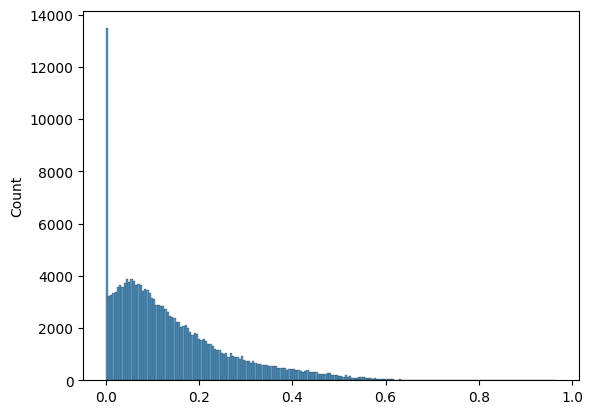

In [18]:
ax = sns.histplot(all_cos_sims.numpy(), bins=200, stat='count') 

## Generate Labels

In [19]:
threshold = global_percentile_dict[75]
stable_rain = []
unstable_rain = []
trg_means = []

for trgcode in trgcodes: ## Labels for all graphs are generated using threshold computed on training set
    trg_mean = cos_sim_dict[trgcode].mean() - 0.125
    trg_means.append(trg_mean.item())

    if (trg_mean >= threshold):
        stable_rain.append(trgcode)
    else:
        unstable_rain.append(trgcode)

<Axes: ylabel='Count'>

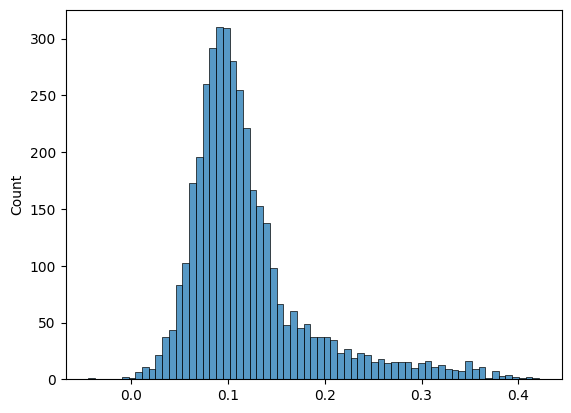

In [20]:
sns.histplot(trg_means)

In [21]:
print(len(stable_rain))
print(len(unstable_rain))

416
3516


In [22]:
stable_dataset = dataset[dataset['TRGCODE'].isin(stable_rain)]
unstable_dataset = dataset[dataset['TRGCODE'].isin(unstable_rain)]

In [23]:
print(len(stable_rain))
print(len(unstable_rain))

416
3516


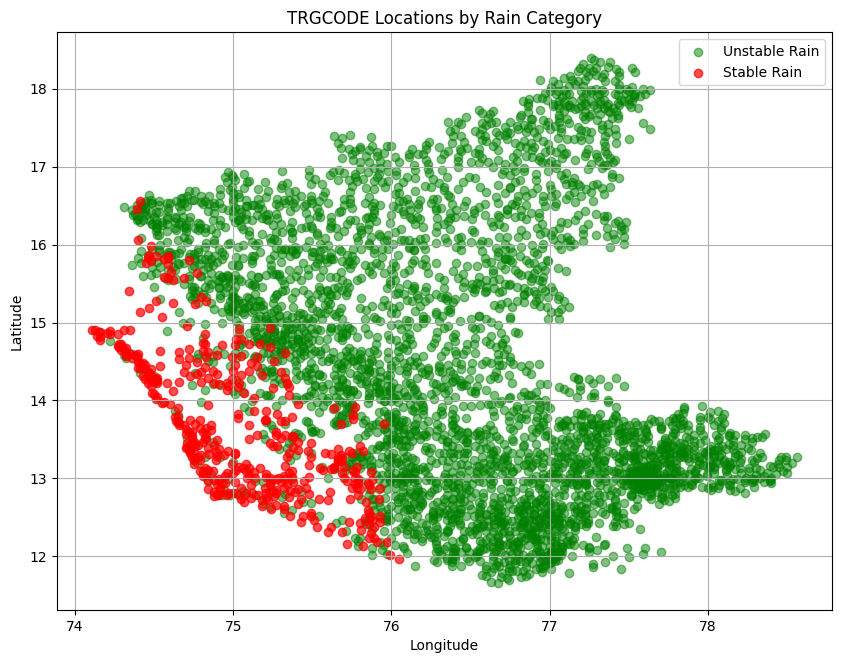

In [24]:
plt.figure(figsize=(10, 7.5))

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('TRGCODE Locations by Rain Category')
plt.legend()
plt.grid()
plt.show()

In [25]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

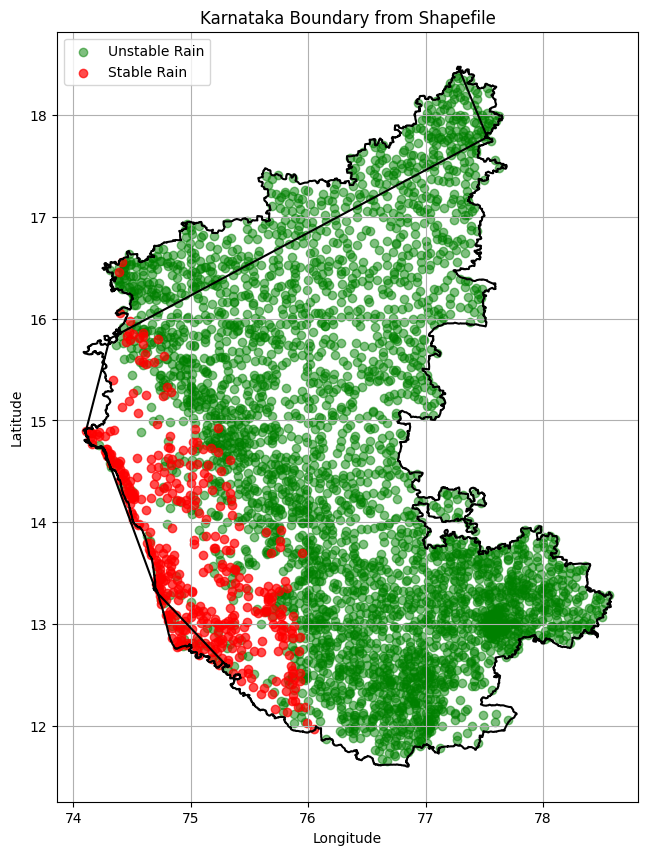

In [26]:
plt.figure(figsize=(7.5, 10))
for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

plt.scatter(unstable_dataset['LONGITUDE'], unstable_dataset['LATITUDE'], color='green', label='Unstable Rain', alpha=0.5)
plt.scatter(stable_dataset['LONGITUDE'], stable_dataset['LATITUDE'], color='red', label='Stable Rain', alpha=0.7)

plt.title("Karnataka Boundary from Shapefile")
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

# Generating the Graphs

In [27]:
for trgcode in trgcodes: ## Mean for all graphs can be computed together
    sum = np.zeros(np.shape(year_wise_dict[trgcode][2022]))

    for year in years:
        sum += year_wise_dict[trgcode][year]

    year_wise_dict[trgcode]['MEAN'] = sum / len(years)

## Training Graph Generation

In [28]:
train_graphs = {}

for trgcode in train_trgcodes:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = cos_sim_dict[trgcode][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [year_wise_dict[trgcode]['MEAN']]

    for year in years:
        node_features.append(year_wise_dict[trgcode][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    if (trgcode in stable_rain):
        label = torch.tensor([1])
    else: 
        label = torch.tensor([0])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    train_graphs[trgcode] = graph

The randomly selected TRGCODE is 468


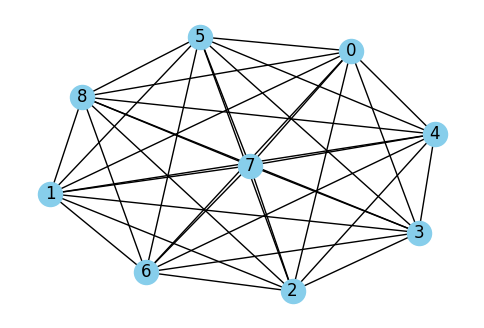

In [59]:
rand_trg = np.random.choice(train_trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

G = to_networkx(train_graphs[rand_trg], to_undirected=True)

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

In [60]:
print(rand_trg in stable_rain)

True


## Testing Graph Generation

In [31]:
test_graphs = {}

for trgcode in test_trgcodes:

    edge_list = []

    for i in range(len(years)):
        
        ## 0 is considered as the average node, and each year node has the index (year - 2014)
        edge_list.append([[i + 1], [0]])

        for j in range(len(years)):
            if i < j:
                score = cos_sim_dict[trgcode][i][j]

                if score > threshold:
                    ## Each year node has the index (year - 2014)
                    edge_list.append([[i + 1], [j + 1]])

    edge_list = np.hstack(edge_list)
    edge_list = torch.tensor(edge_list, dtype=torch.long)

    node_features = [year_wise_dict[trgcode]['MEAN']]

    for year in years:
        node_features.append(year_wise_dict[trgcode][year])

    node_features = np.vstack(node_features)
    node_features = torch.tensor(node_features, dtype=torch.float)

    if (trgcode in stable_rain):
        label = torch.tensor([1])
    else: 
        label = torch.tensor([0])

    graph = Data(x=node_features, edge_index=edge_list, y=label)

    test_graphs[trgcode] = graph

The randomly selected TRGCODE is 592


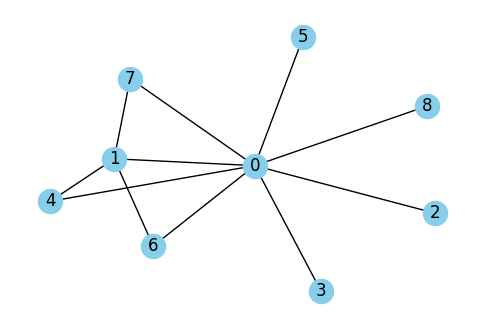

In [32]:
rand_trg = np.random.choice(test_trgcodes)
print(f"The randomly selected TRGCODE is {rand_trg}")

G = to_networkx(test_graphs[rand_trg], to_undirected=True)

fig, ax = plt.subplots(figsize=(6, 4))
nx.draw(G, ax=ax, with_labels=True, node_size=300, node_color='skyblue')
plt.show()

In [33]:
print(rand_trg in stable_rain)

False


# Training the Model

In [34]:
stratify_labels = [graph.y.item() for graph in train_graphs.values()]

In [35]:
print(len(train_graphs))
print(len(test_graphs))

3145
787


In [36]:
train_loader = DataLoader(list(train_graphs.values()), batch_size=128, shuffle=True)
test_loader = DataLoader(list(test_graphs.values()), batch_size=32, shuffle=True)

In [37]:
stable = 0
unstable = 0

for trgcode in train_trgcodes:
    if trgcode in stable_rain:
        stable += 1
    else:
        unstable += 1

print(f'Number of stable locations in training set: {stable}')
print(f'Number of unstable locations in training set: {unstable}')
print(f'Percentage of stable in training set: {stable / (stable + unstable) * 100:.4f}')

Number of stable locations in training set: 334
Number of unstable locations in training set: 2811
Percentage of stable in training set: 10.6200


In [38]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=[0, 1],
    y=[g.y.item() for g in train_graphs.values()]
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(class_weights_tensor)

tensor([0.5594, 4.7081])


In [39]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(3707)
        self.conv1 = GCNConv(122, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels) ## Same size to refine node embeddings
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        ## STEP 1: To obtain node embeddings
        x = self.conv1(x, edge_index) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=0.5, training=self.training)

        ## STEP 2: Readout layer
        x = global_max_pool(x, batch) ## Computes batch wise mean of the graphs that have been batched. Returns one feature vector per batch

        ## STEP 3: Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training) ## Dropout is regularization to prevent overfitting
        x = self.lin(x)

        return x

In [40]:
model = GCN(hidden_channels=32)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=5,
    verbose=True
)

criterion = torch.nn.CrossEntropyLoss(weight=class_weights_tensor) 

def train(train_loader):
    model.train() ## Toggles training mode. Enables dropout, updates running statistics, etc. READ MORE.

    total_loss = 0

    for train_graph in train_loader:
        out = model(train_graph.x.float(), train_graph.edge_index, train_graph.batch) ## A single forward pass
        loss = criterion(out, train_graph.y.long()) ## Compute cross entropy loss
        loss.backward() ## Find the gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step() ## Update parameters based on gradients
        optimizer.zero_grad() ## Clear gradients
        total_loss += loss.item() * train_graph.num_graphs

    return total_loss / len(train_loader.dataset)

def test(test_loader):
    model.eval() ## Toggles testing behaviour. READ MORE.

    correct = 0

    for graph in test_loader:
        out = model(graph.x.float(), graph.edge_index, graph.batch)
        prediction = out.argmax(dim=1) ## Use the class with highest probability
        correct += int((prediction == graph.y).sum())
    
    return correct / len(test_loader.dataset)

/home/prad/.local/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [41]:
losses = list()
train_accuracies = list()
test_accuracies = list()

best_test_accuracy = 0
patience_counter = 0
patience = 10

for epoch in range(1, 120):
    loss = train(train_loader)
    losses.append(loss)
    train_accuracy = test(train_loader)
    test_accuracy = test(test_loader)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    print(f'Epoch: {epoch:03d}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}, Patience Counter: {patience_counter}')

    scheduler.step(test_accuracy)

    if (test_accuracy > best_test_accuracy):
        best_test_accuracy = test_accuracy
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1

    if patience_counter > patience:
        print("----- Early stopping triggered -----")
        break

Epoch: 001, Train Accuracy: 0.9342, Test Accuracy: 0.9314, Patience Counter: 0
Epoch: 002, Train Accuracy: 0.9027, Test Accuracy: 0.9009, Patience Counter: 0
Epoch: 003, Train Accuracy: 0.9485, Test Accuracy: 0.9504, Patience Counter: 1
Epoch: 004, Train Accuracy: 0.9453, Test Accuracy: 0.9479, Patience Counter: 0
Epoch: 005, Train Accuracy: 0.9501, Test Accuracy: 0.9504, Patience Counter: 1
Epoch: 006, Train Accuracy: 0.9548, Test Accuracy: 0.9581, Patience Counter: 2
Epoch: 007, Train Accuracy: 0.9529, Test Accuracy: 0.9555, Patience Counter: 0
Epoch: 008, Train Accuracy: 0.9653, Test Accuracy: 0.9657, Patience Counter: 1
Epoch: 009, Train Accuracy: 0.9596, Test Accuracy: 0.9568, Patience Counter: 0
Epoch: 010, Train Accuracy: 0.9587, Test Accuracy: 0.9530, Patience Counter: 1
Epoch: 011, Train Accuracy: 0.9447, Test Accuracy: 0.9454, Patience Counter: 2
Epoch: 012, Train Accuracy: 0.9431, Test Accuracy: 0.9454, Patience Counter: 3
Epoch: 013, Train Accuracy: 0.9618, Test Accuracy: 0

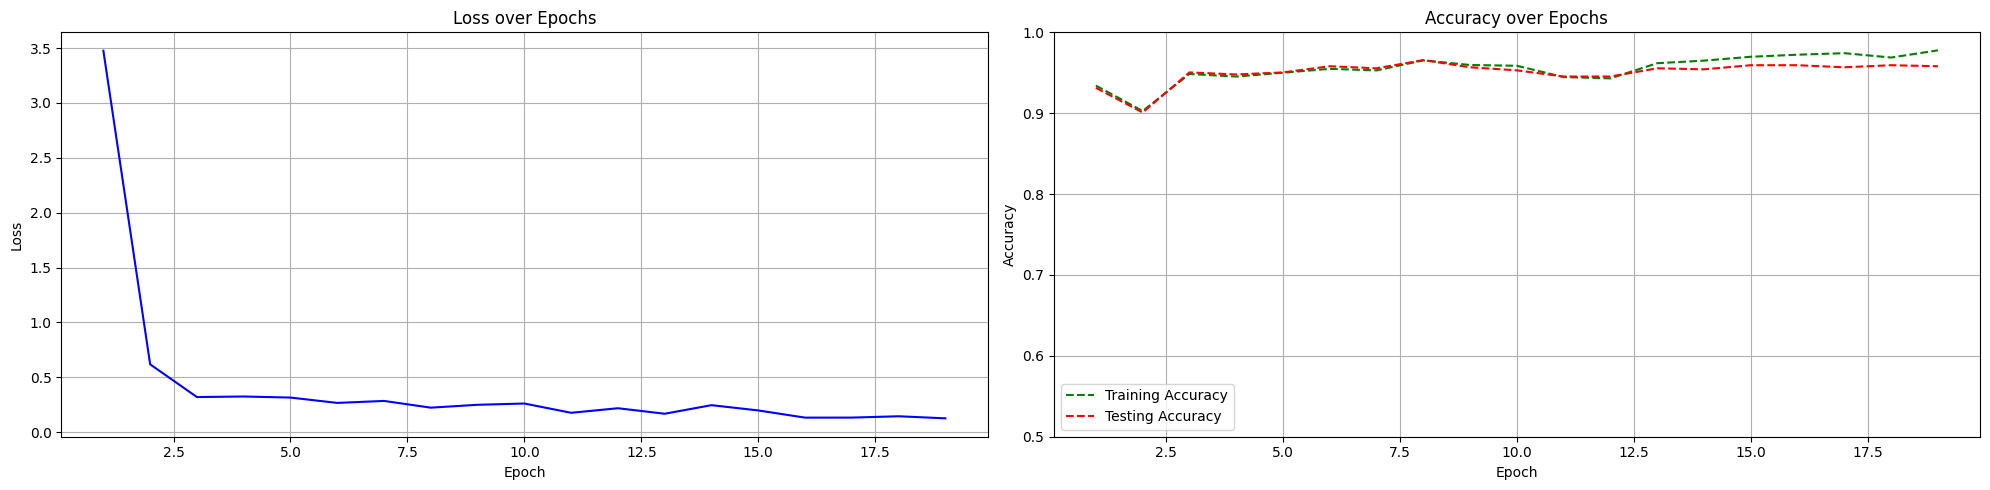

In [42]:
epochs = range(1, len(losses) + 1)

plt.figure(figsize=(20, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, 'b-')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'g--', label='Training Accuracy')
plt.plot(epochs, test_accuracies, 'r--', label='Testing Accuracy')
plt.legend()
plt.ylim(0.5, 1)
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

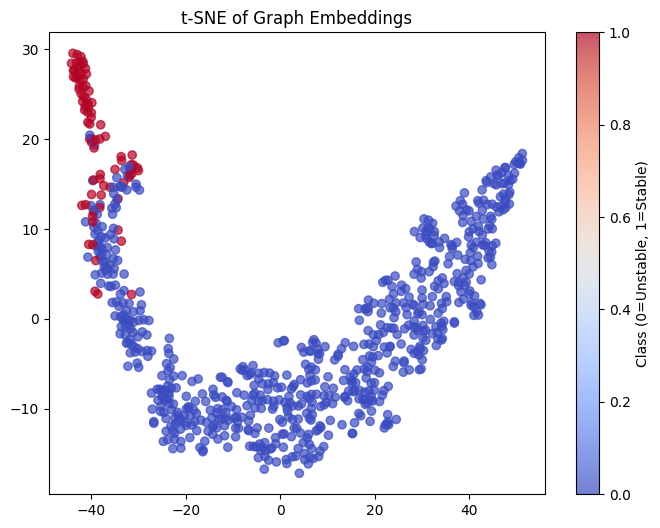

In [63]:
model.eval()
embeddings = []
labels = []

with torch.no_grad():
    for graph in test_graphs.values():
        x = graph.x.float()
        edge_index = graph.edge_index
        batch = torch.zeros(x.size(0), dtype=torch.long)
        out = model.conv1(x, edge_index)
        out = out.relu()
        out = model.conv2(out, edge_index)
        graph_embed = global_max_pool(out, batch)
        
        embeddings.append(graph_embed.cpu().numpy())
        labels.append(graph.y.item())

# Reduce to 2D
embeddings_2d = TSNE(n_components=2).fit_transform(np.vstack(embeddings))

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("t-SNE of Graph Embeddings")
plt.colorbar(label="Class (0=Unstable, 1=Stable)")
plt.show()

# Testing the Model

In [64]:
model.eval()

test_y_pred = list()

for graph in test_graphs.values():
    
    with torch.no_grad():
        num_nodes = graph.x.size(0)
        batch = torch.zeros(num_nodes, dtype=torch.long)
        out = model(graph.x.float(), graph.edge_index, batch)
        prediction = out.argmax(dim=1).item()

    test_y_pred.append(prediction)

print(len(test_y_pred))

787


In [65]:
test_y_true = list()

for trgcode in test_graphs.keys():
    test_y_true.append(int(trgcode in stable_rain))

print(len(test_y_true))

787


Confusion Matrix:
[[682  23]
 [ 10  72]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.99      0.97      0.98       705
      Stable       0.76      0.88      0.81        82

    accuracy                           0.96       787
   macro avg       0.87      0.92      0.89       787
weighted avg       0.96      0.96      0.96       787



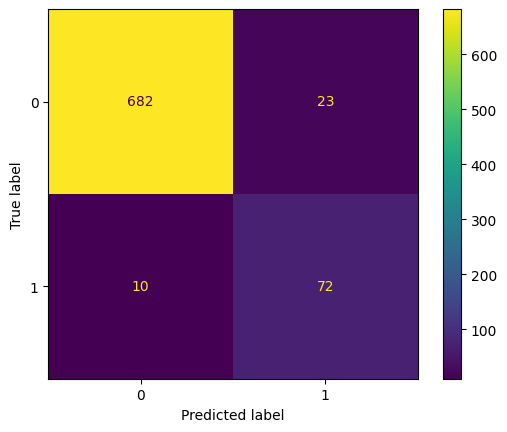

In [66]:
test_confu_mat = confusion_matrix(test_y_true, test_y_pred)
print('Confusion Matrix:')
print(test_confu_mat)

ConfusionMatrixDisplay(test_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(test_y_true, test_y_pred, target_names=['Unstable', 'Stable']))

# Rainfall Magnitude Analysis

For this section, I will try to classify rainfall based on the following image.

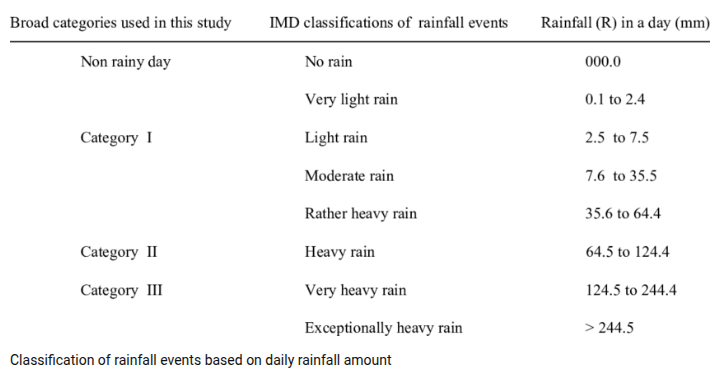

I will classify as (all values are in mm/day):-

- Very Light Rain: 0 - 2.4
- Light Rain: 2.5 - 7.5
- Moderate Rain: 7.6 - 35.5
- Rather Heavy Rain: 35.6 - 64.4
- Heavy Rain: 64.5 - 124.4
- Very Heavy Rain: 124.5 +

In [46]:
def get_avg_rainfall(trgcode):
    
    sum = 0

    for year in years:
        for day in year_wise_dict[trgcode][year]:
            sum += day

    avg_rainfall = sum / (122 * 8)

    return avg_rainfall

In [47]:
rainfall = {
    'very_light': [],
    'light': [],
    'moderate': [],
    'rather_heavy': [],
    'heavy': [],
    'very_heavy': []
}

for trgcode in trgcodes:
    avg_rainfall = get_avg_rainfall(trgcode)

    if (avg_rainfall <= 2.4):
        rainfall['very_light'].append(trgcode)
    elif (avg_rainfall <= 7.5):
        rainfall['light'].append(trgcode)
    elif (avg_rainfall <= 35.5):
        rainfall['moderate'].append(trgcode)
    elif (avg_rainfall <= 64.4):
        rainfall['rather_heavy'].append(trgcode)
    elif (avg_rainfall <= 124.4):
        rainfall['heavy'].append(trgcode)
    else:
        rainfall['very_heavy'].append(trgcode)

In [48]:
for key in rainfall.keys():
    print(f"Number of {key} rainfall areas: {len(rainfall[key])}")

Number of very_light rainfall areas: 1703
Number of light rainfall areas: 1803
Number of moderate rainfall areas: 426
Number of rather_heavy rainfall areas: 0
Number of heavy rainfall areas: 0
Number of very_heavy rainfall areas: 0


In [49]:
for key in rainfall.keys():
    sum = 0

    for trgcode in rainfall[key]:
        if trgcode in test_trgcodes:
            sum += 1

    print(f"Number of {key} rainfall areas in testing set: {sum}")

Number of very_light rainfall areas in testing set: 349
Number of light rainfall areas in testing set: 352
Number of moderate rainfall areas in testing set: 86
Number of rather_heavy rainfall areas in testing set: 0
Number of heavy rainfall areas in testing set: 0
Number of very_heavy rainfall areas in testing set: 0


## Very Light

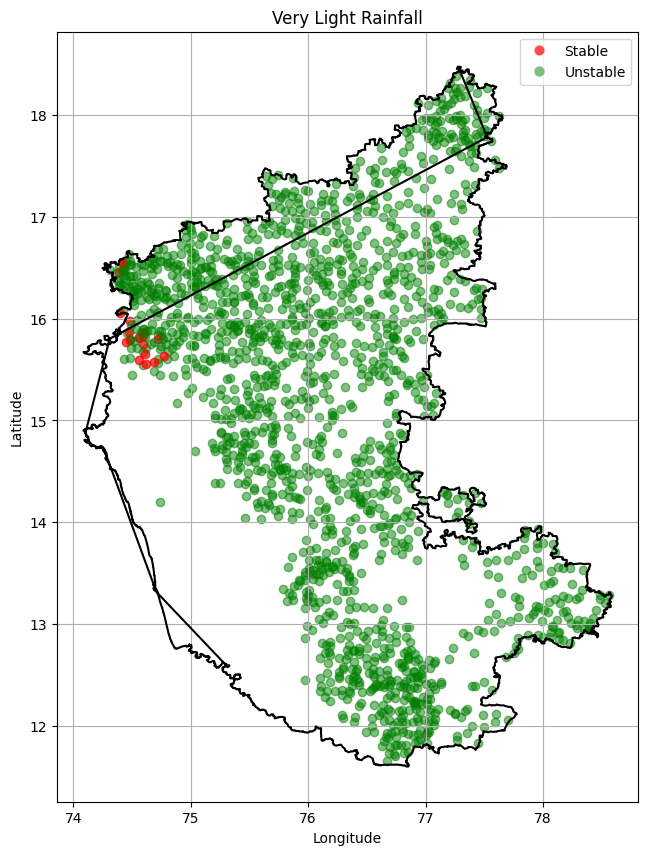

In [50]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['very_light']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Very Light Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [67]:
model.eval()

very_light_y_pred = list()

for trgcode in rainfall['very_light']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        very_light_y_pred.append(prediction)

very_light_y_true = list()

for trgcode in rainfall['very_light']:
    if trgcode in test_trgcodes:
        very_light_y_true.append(int(trgcode in stable_rain))

print(len(very_light_y_pred))
print(len(very_light_y_true))

349
349


Confusion Matrix:
[[342   4]
 [  0   3]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       1.00      0.99      0.99       346
      Stable       0.43      1.00      0.60         3

    accuracy                           0.99       349
   macro avg       0.71      0.99      0.80       349
weighted avg       1.00      0.99      0.99       349



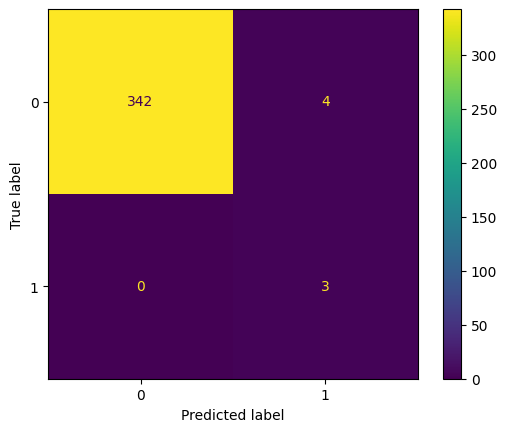

In [68]:
very_light_confu_mat = confusion_matrix(very_light_y_true, very_light_y_pred)
print('Confusion Matrix:')
print(very_light_confu_mat)

ConfusionMatrixDisplay(very_light_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(very_light_y_true, very_light_y_pred, target_names=['Unstable', 'Stable']))

## Light

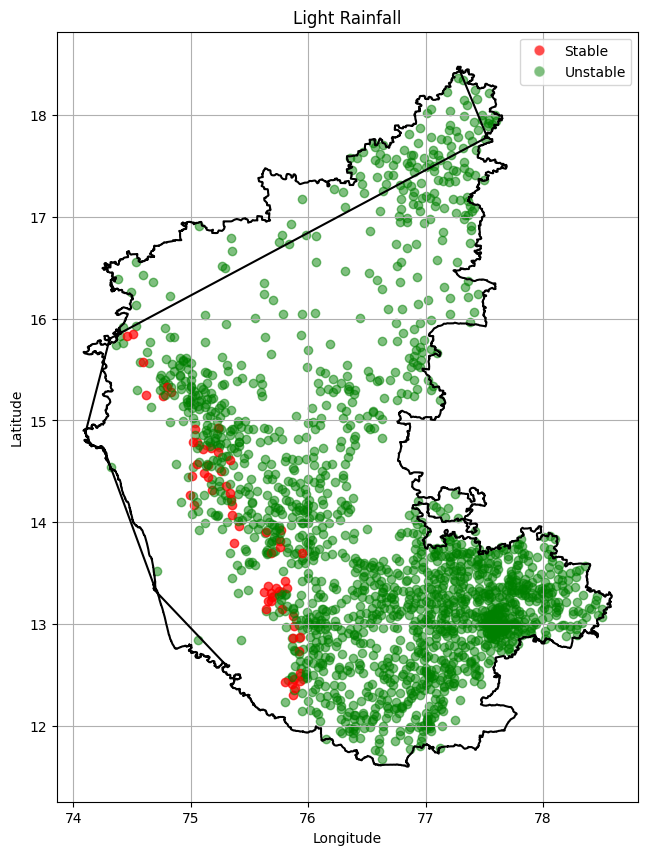

In [53]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['light']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Light Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [69]:
model.eval()

light_y_pred = list()

for trgcode in rainfall['light']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        light_y_pred.append(prediction)

light_y_true = list()

for trgcode in rainfall['light']:
    if trgcode in test_trgcodes:
        light_y_true.append(trgcode in stable_rain)

print(len(light_y_pred))
print(len(light_y_true))

352
352


Confusion Matrix:
[[330   9]
 [  7   6]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.98      0.97      0.98       339
      Stable       0.40      0.46      0.43        13

    accuracy                           0.95       352
   macro avg       0.69      0.72      0.70       352
weighted avg       0.96      0.95      0.96       352



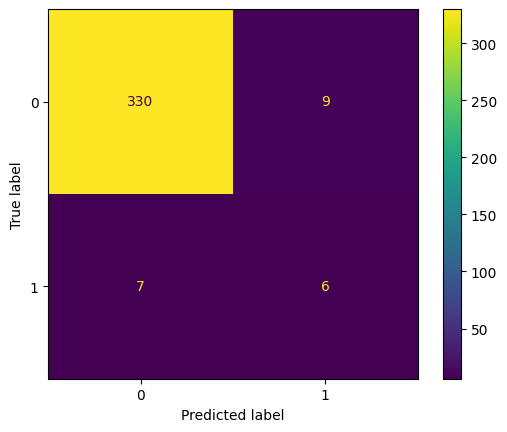

In [70]:
light_confu_mat = confusion_matrix(light_y_true, light_y_pred)
print('Confusion Matrix:')
print(light_confu_mat)

ConfusionMatrixDisplay(light_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(light_y_true, light_y_pred, target_names=['Unstable', 'Stable']))

## Moderate                                         

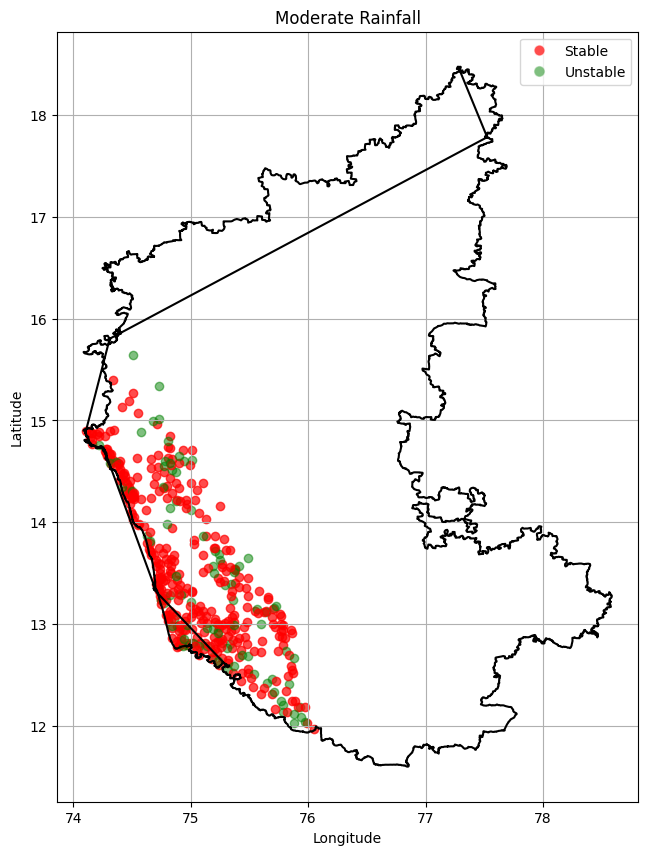

In [56]:
karnataka = shapefile.Reader("Karnataka/State.shp")

transformer = Transformer.from_crs("EPSG:32643", "EPSG:4326", always_xy=True)

plt.figure(figsize=(7.5, 10))

for shape in karnataka.shapes():
    points = shape.points
    lon_lat = [transformer.transform(x, y) for x, y in points]
    x = [pt[0] for pt in lon_lat]
    y = [pt[1] for pt in lon_lat]
    plt.plot(x, y, 'k')

for trgcode in rainfall['moderate']:

    if trgcode in stable_rain:
        color = 'red'
        alpha = 0.7
    else:
        color = 'green'
        alpha = 0.5

    plt.scatter(
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LONGITUDE'],
        dataset.loc[dataset['TRGCODE'] == trgcode, 'LATITUDE'],
        color=color,
        alpha=alpha
    )

legend_elements = [
    lines.Line2D([0], [0], marker='o', color='w', label='Stable', markerfacecolor='red', markersize=8, alpha=0.7),
    lines.Line2D([0], [0], marker='o', color='w', label='Unstable', markerfacecolor='green', markersize=8, alpha=0.5)
]

plt.title("Moderate Rainfall")
plt.legend(handles=legend_elements)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [71]:
model.eval()

moderate_y_pred = list()

for trgcode in rainfall['moderate']:
    if trgcode in test_trgcodes:
        graph = test_graphs[trgcode]
        
        with torch.no_grad():
            num_nodes = graph.x.size(0)
            batch = torch.zeros(num_nodes, dtype=torch.long)
            out = model(graph.x.float(), graph.edge_index, batch)
            prediction = out.argmax(dim=1).item()

        moderate_y_pred.append(prediction)

moderate_y_true = list()

for trgcode in rainfall['moderate']:
    if trgcode in test_trgcodes:
        moderate_y_true.append(trgcode in stable_rain)

print(len(moderate_y_pred))
print(len(moderate_y_true))

86
86


Confusion Matrix:
[[10 10]
 [ 3 63]]

Classification Report:
              precision    recall  f1-score   support

    Unstable       0.77      0.50      0.61        20
      Stable       0.86      0.95      0.91        66

    accuracy                           0.85        86
   macro avg       0.82      0.73      0.76        86
weighted avg       0.84      0.85      0.84        86



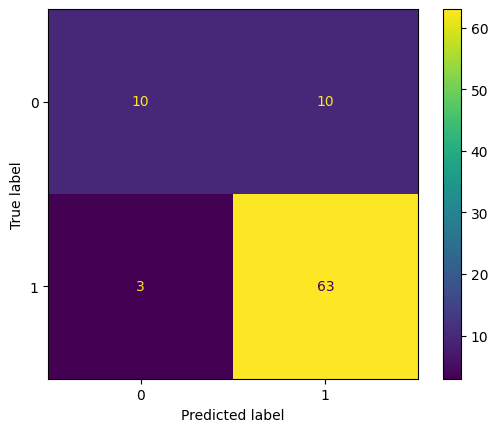

In [72]:
moderate_confu_mat = confusion_matrix(moderate_y_true, moderate_y_pred)
print('Confusion Matrix:')
print(moderate_confu_mat)

ConfusionMatrixDisplay(moderate_confu_mat).plot()

print('\nClassification Report:')
print(classification_report(moderate_y_true, moderate_y_pred, target_names=['Unstable', 'Stable']))

In [73]:
print('\nClassification Report (Test):')
print(classification_report(test_y_true, test_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Very Light):')
print(classification_report(very_light_y_true, very_light_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Light):')
print(classification_report(light_y_true, light_y_pred, target_names=['Unstable', 'Stable']))

print('\nClassification Report (Moderate):')
print(classification_report(moderate_y_true, moderate_y_pred, target_names=['Unstable', 'Stable']))


Classification Report (Test):
              precision    recall  f1-score   support

    Unstable       0.99      0.97      0.98       705
      Stable       0.76      0.88      0.81        82

    accuracy                           0.96       787
   macro avg       0.87      0.92      0.89       787
weighted avg       0.96      0.96      0.96       787


Classification Report (Very Light):
              precision    recall  f1-score   support

    Unstable       1.00      0.99      0.99       346
      Stable       0.43      1.00      0.60         3

    accuracy                           0.99       349
   macro avg       0.71      0.99      0.80       349
weighted avg       1.00      0.99      0.99       349


Classification Report (Light):
              precision    recall  f1-score   support

    Unstable       0.98      0.97      0.98       339
      Stable       0.40      0.46      0.43        13

    accuracy                           0.95       352
   macro avg       0.69     